In [273]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [274]:
df = pd.read_csv("/content/No_id_Candidate_Final (4).csv")

In [275]:
df.isnull().values.any()

False

In [276]:
df.shape

(120000, 11)

In [277]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [278]:
frauds.shape

(11265, 11)

In [279]:
normal.shape

(108735, 11)

In [280]:
frauds.head()

,Unnamed: 0,User_id,Signup_time,Purchase_time,Purchase_value,Source,Browser,Sex,Age,Ip_address,Class
12,68779,264899,42016.48819,42016.48819,57,0.2,0.33,0.4,32,1.288372e+09,1
27,118822,41373,42010.57083,42010.57083,56,0.4,0.33,0.4,27,1.239228e+09,1
36,147030,343842,42075.77569,42077.95417,34,0.6,0.66,0.6,33,7.166723e+08,1
45,27845,37810,42010.59931,42010.59931,60,0.4,0.33,0.4,58,1.969298e+09,1
58,132134,238906,42011.90903,42050.72847,61,0.6,0.66,0.6,38,4.019587e+09,1


In [281]:
# purchase value = amount

frauds.Purchase_value.describe()

count    11265.000000
mean        37.066134
std         18.428676
min          9.000000
25%         22.000000
50%         35.000000
75%         49.000000
max        111.000000
Name: Purchase_value, dtype: float64

In [282]:
normal.Purchase_value.describe()

count    108735.000000
mean         36.862344
std          18.315148
min           9.000000
25%          22.000000
50%          34.000000
75%          49.000000
max         154.000000
Name: Purchase_value, dtype: float64

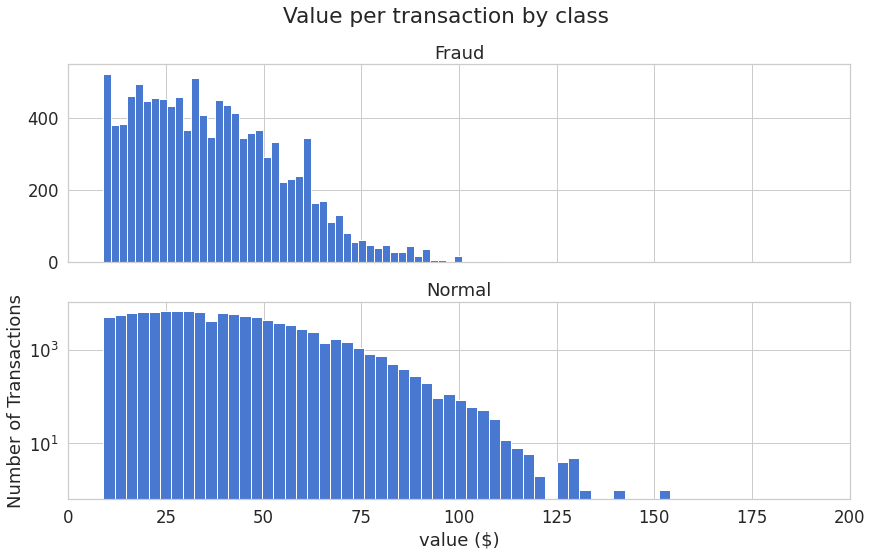

In [283]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Value per transaction by class')

bins = 50

ax1.hist(frauds.Purchase_value, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Purchase_value, bins = bins)
ax2.set_title('Normal')

plt.xlabel('value ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 200))
plt.yscale('log')
plt.show();

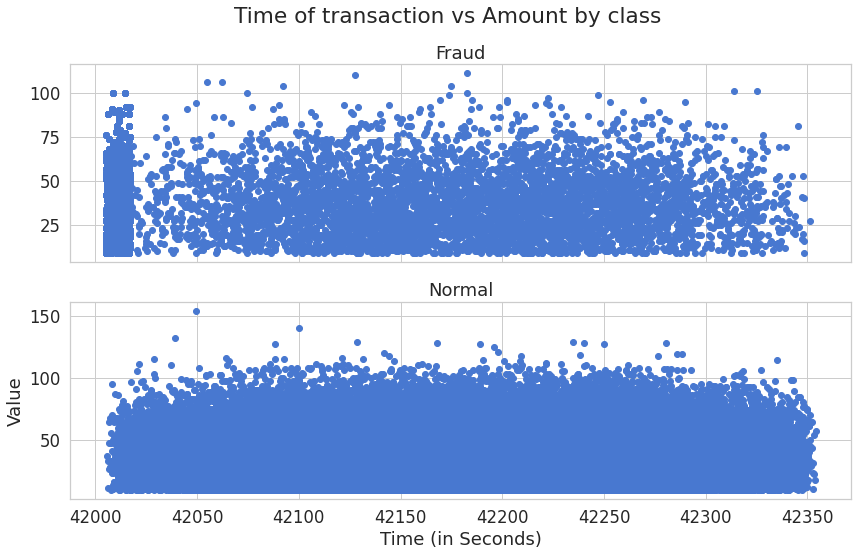

In [284]:

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Purchase_time, frauds.Purchase_value)
ax1.set_title('Fraud')

ax2.scatter(normal.Purchase_time, normal.Purchase_value)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Value')
plt.show()

In [293]:
from sklearn.preprocessing import StandardScaler
# import preprocessing and then limiting the values from 0 to 1 to help limit RNN loss
data = df.drop(['Purchase_time'], axis=1)

data['Signup_time'] = MinMaxScaler().fit_transform(data['Signup_time'].values.reshape(-1, 1), (0, 1))
data['Purchase_value'] = MinMaxScaler().fit_transform(data['Purchase_value'].values.reshape(-1, 1))
data['Ip_address'] = MinMaxScaler().fit_transform(data['Ip_address'].values.reshape(-1, 1), (0, 1))
data['Unnamed: 0'] = MinMaxScaler().fit_transform(data['Unnamed: 0'].values.reshape(-1, 1), (0, 1))
#data['Source'] = MinMaxScaler().fit_transform(data['Purchase_value'].values.reshape(-1, 1))
data['Age'] = MinMaxScaler().fit_transform(data['Age'].values.reshape(-1, 1), (0, 1))
data['User_id'] = MinMaxScaler().fit_transform(data['User_id'].values.reshape(-1, 1), (0, 1))
#data['Browser'] = MinMaxScaler().fit_transform(data['Browser'].values.reshape(-1, 1), (0, 1))
#data['Sex'] = MinMaxScaler().fit_transform(data['Sex'].values.reshape(-1, 1), (0.5, 1))

In [286]:
data.head()

,Unnamed: 0,User_id,Signup_time,Purchase_value,Source,Browser,Sex,Age,Ip_address,Class
0,0.990464,0.712769,0.851665,0.151724,0.2,0.33,0.4,0.534483,0.656220,0
1,0.103302,0.327519,0.102624,0.151724,0.4,0.16,0.6,0.051724,0.757010,0
2,0.484260,0.822137,0.301226,0.048276,0.2,0.16,0.4,0.137931,0.635116,0
3,0.559489,0.572630,0.028600,0.137931,0.4,0.33,0.4,0.275862,0.485086,0
4,0.238083,0.271094,0.169654,0.117241,0.6,0.50,0.4,0.258621,0.746915,0


In [287]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [288]:
X_train.shape

(86967, 9)

In [289]:
input_dim = X_train.shape[1]
encoding_dim = 4

In [290]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="sigmoid", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder1 = Dense(50, activation="sigmoid")(encoder)

decoder = Dense(50, activation='sigmoid')(encoder1)
decoder1 = Dense(input_dim, activation='softmax')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder1)

In [291]:
nb_epoch = 10
batch_size = 3

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
28969/28989 [============================>.] - ETA: 0s - loss: 0.1794 - accuracy: 0.5696

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [ ]:

predictions = autoencoder.predict(X_test)

In [ ]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [ ]:
error_df.describe()

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [ ]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [ ]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

In [ ]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [ ]:
threshold = 0.4

In [ ]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [ ]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

mean value of fraud os $31 

$8 loss for each false positive